[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/04_geocentric_models.ipynb)

# Chapter 4 - Geocentric Models

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

from scipy.interpolate import BSpline

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

In [6]:
# Tensorflow MCMC sampling helpers

In [7]:
USE_XLA = False              #@param
NUMBER_OF_CHAINS  = 2        #@param 
NUMBER_OF_BURNIN  = 500      #@param
NUMBER_OF_SAMPLES = 500      #@param
NUMBER_OF_LEAPFROG_STEPS = 4 #@param

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior(jdc, 
              observed_data, 
              params, 
              init_state=None, 
              bijectors=None, 
              step_size = 0.1,
              num_chains=NUMBER_OF_CHAINS,                  
              num_samples=NUMBER_OF_SAMPLES, 
              burnin=NUMBER_OF_BURNIN):
        
    if init_state is None:
        init_state = list(jdc.sample(num_chains)[:-1])

    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  

    results, sample_stats = run_hmc_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, 
                           sample_stats=sampler_stats)

    return posterior, az_trace

In [8]:
### Dataset URLs

In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"

HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
CHERRY_BLOSSOMS_DATASET_PATH = f"{_BASE_URL}/cherry_blossoms.csv"

In [10]:
### Plotting utilities

In [11]:
# a function to plot the density using arviz plot_kde function
def plot_density(positions, x_label='Position', y_label='Density'):
    az.plot_kde(positions)
    plt.xlabel(x_label)
    plt.ylabel(y_label)        

## 4.1 Why normal distributions are normal

### 4.1.1 Normal by addition

##### Code 4.1

This snippet is showing the notion of "Normal distribution by Addition"

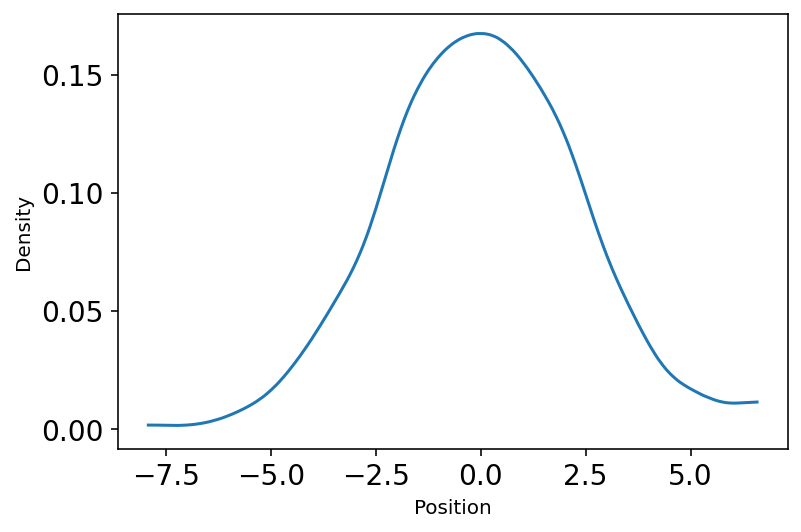

In [12]:
u1 = tfd.Uniform(low=-1.0, high=1.0)
pos = tf.reduce_sum(u1.sample(sample_shape=(16,1000)), axis=0)

plot_density(pos.numpy())

### 4.1.2 Normal by multiplication

##### Code 4.2 & 4.3

This snippet is showing the notion of "Normal distribution by Multiplication"

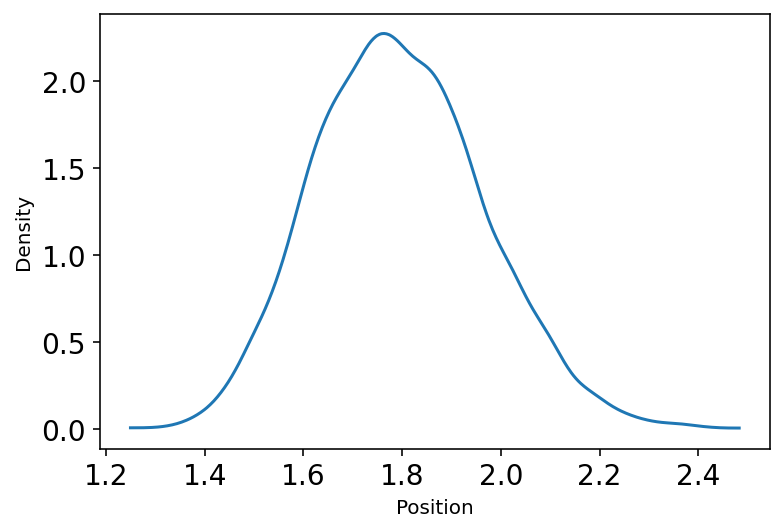

In [13]:
u2 = tfd.Uniform(low=1.0, high=1.1)
pos = tf.reduce_prod(u2.sample(sample_shape=(12,10000)), axis=0)

plot_density(pos.numpy())

##### Code 4.4

Continuation of the notion of "Normal distribution by Multiplication"

Author explains that - "The smaller the effect of a variable (locus in the example), the better the additive approximation will be"

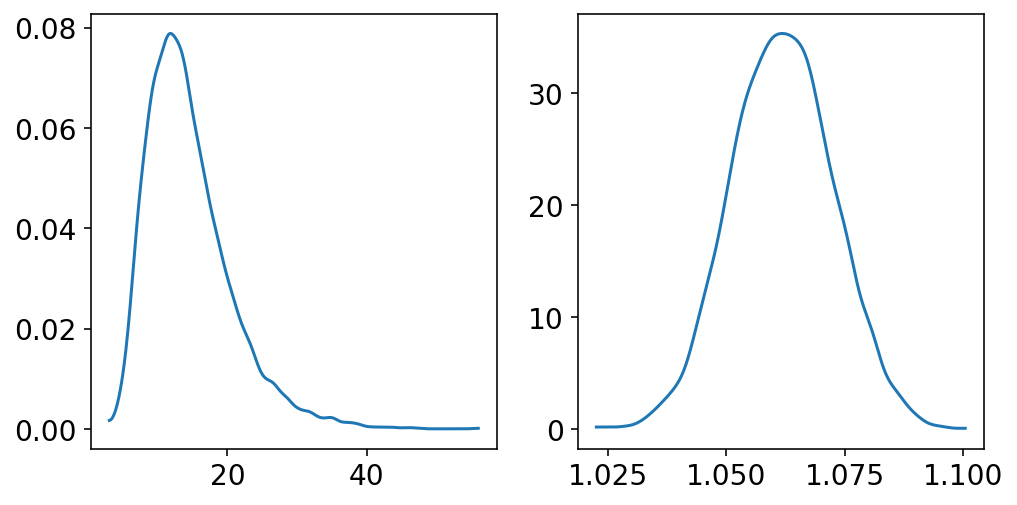

In [14]:
big =  tf.reduce_prod(tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12,10000)), axis=0)
small =  tf.reduce_prod(tfd.Uniform(low=1.0, high=1.01).sample(sample_shape=(12,10000)), axis=0)

_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big.numpy(), ax=ax[0])
az.plot_kde(small.numpy(), ax=ax[1]);

### 4.1.3 Normal by log-multiplication

##### Code 4.5

This snippet is showing the notion of "Normal distribution by log-multiplication"

Author explains - "Large deviates that are multi- plied together do not produce Gaussian distributions, but they do tend to produce Gaussian distributions on the log scale. So even multiplicative interactions of large deviations can produce Gaussian distributions, once we measure the outcomes on the log scale."

In [15]:
log_big = tf.math.log(tf.reduce_prod(tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12,10000)), axis=0))

## 4.2 A language for describing models

##### Code 4.6

Here the globe tossing model is described again.

$w$ = Observed count of water

$n$ = Total number of tosses

$p$ = Proportion of water on the globel


This is the first introduction/usage of Bayes' Theorem


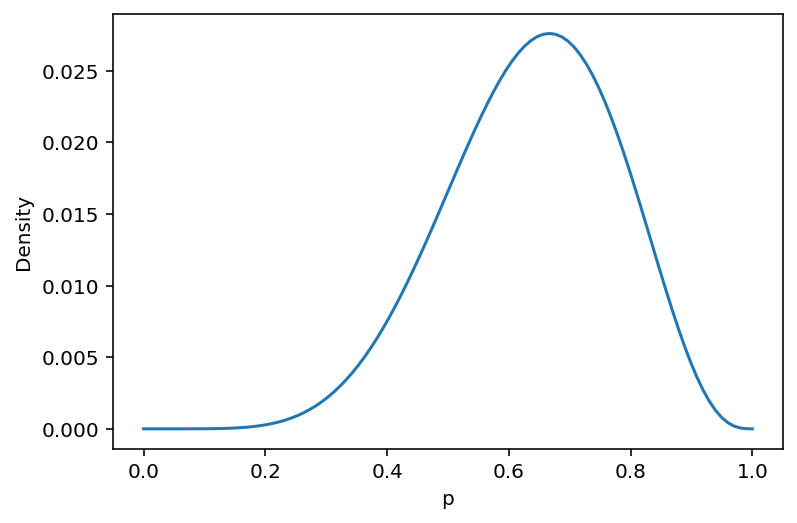

In [16]:
w, n = 6.0, 9.0

p_grid = tf.linspace(0.0, 1.0, 100)
 
b1_dist = tfd.Binomial(total_count=n, probs=p_grid)
u3_dist = tfd.Uniform(low=0.0, high=1.0)

posterior = b1_dist.prob(w) * u3_dist.prob(p_grid)
posterior = posterior / tf.reduce_sum(posterior)

plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

## 4.3 Gaussian model of height

### 4.3.1 The data

##### Code 4.7, 4.8 


We are now building the Gaussian model of height


In [17]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


##### Code 4.9

In [18]:
az.summary(d.to_dict(orient="list"), kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.264,27.602,90.805,170.180
weight,35.611,14.719,11.368,55.707
age,29.344,20.747,0.000,57.000
male,0.472,0.500,0.000,1.000


##### Code 4.10

For now we are going to work only with the height columns so let's look at it

In [19]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

##### Code 4.11

We are only interested in the heights of adults only (for the time being; we will incorporate the whole dataset later)

In [20]:
d2 = d[d.age >= 18]

### 4.3.2 The model

##### Code 4.12 & 4.13

Author explains that whatever is your prior, it's a very good idea to always plot it. This way we will have a better
sense of our model.

Here we have assumed certain values for our priors and as per the instruction plotting them

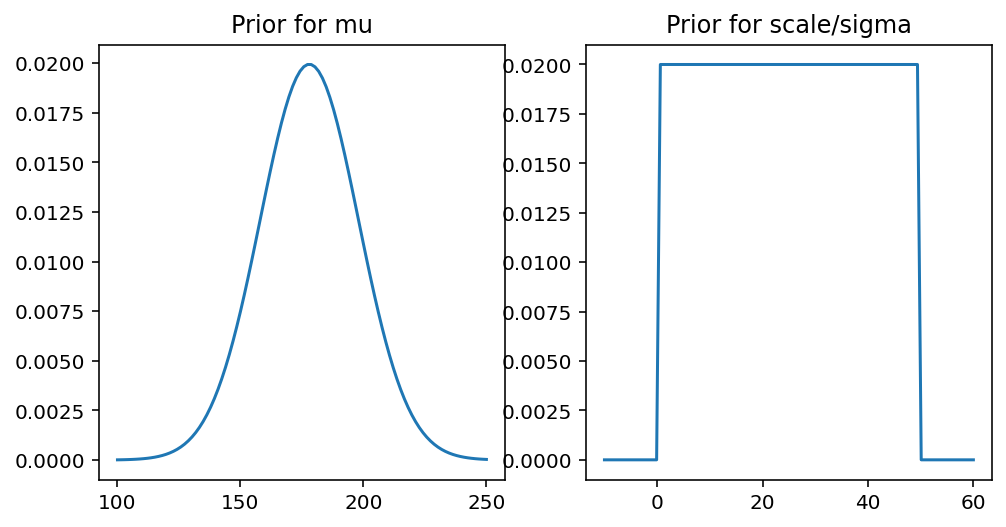

In [21]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

x = tf.linspace(100.0, 250.0, 100)
mu_prior = tfd.Normal(loc=178.0, scale=20.0)
ax1.set_title('Prior for mu')
ax1.plot(x, mu_prior.prob(x));

x = tf.linspace(-10.0, 60.0, 100)
scale_prior = tfd.Uniform(low=0.0, high=50.0)
ax2.set_title('Prior for scale/sigma')
ax2.plot(x, scale_prior.prob(x));

##### Code 4.14

In the above section we have chosen priors for $h$, $\mu$, $\sigma$ and even plotted them. It is also important to now see what kind of distribution these assumptions generate. This is called **PRIOR PREDICTIVE simulation** and is important part of modelling.

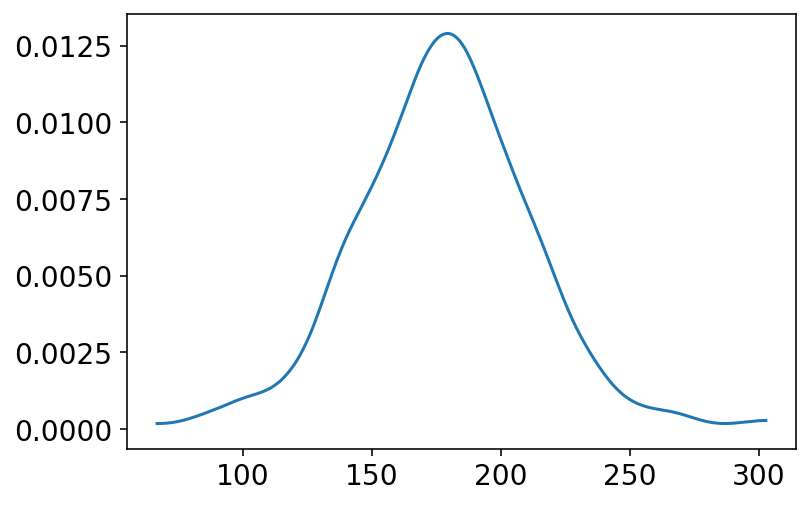

In [22]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=20.0).sample(n_samples)
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples)
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample()

az.plot_kde(prior_h.numpy());

##### Code 4.15

As mentioned in above cell the prior predictive simulation is helpful in assigning sensible priors. Here we see if we change the scale for *sample_mu* to 100 (instead of using 20 as in the above cell)

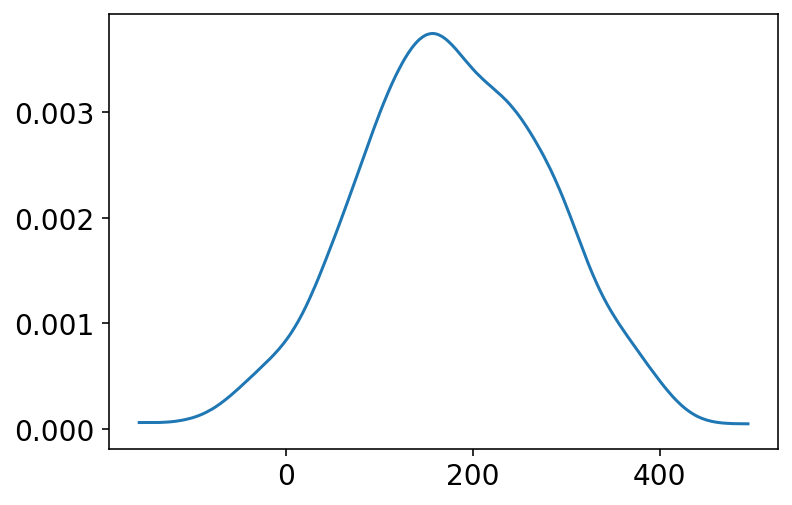

In [23]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=100.0).sample(n_samples)
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples)
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample()

az.plot_kde(prior_h.numpy());

Now, what the above plot is showing that there are about 4% of people that have a **negative height** and about 18% on the right side have height not common at all for humans to attain ! So clearly this choice of scale (i.e. 100) is not a good one as the prior. 

### 4.3.3 Grid approximation of the posterior distribution

##### Code 4.16

Here we are doing **Grid approximation of the posterior distribution**. A very crude technique that may work for small/simple models. It is customary to do it to make a point but later we will use well established inference methods based on MCMC and VI

In [24]:
def compute_likelihood(mu, sigma, sample_data):
    
    def _compute(i):
        norm_dist = tfd.Normal(loc=mu[i], scale=sigma[i])
        return tf.reduce_sum(norm_dist.log_prob(sample_data))    

    # Note the usage of vectorized_map
    # This essentially runs a parallel loop and makes a difference
    # in the computation of likelihood when the samples size is large
    # which is the case for us
    return tf.vectorized_map(_compute, np.arange(mu.shape[0]))    


def grid_approximation(sample_data, mu_start=150., mu_stop=160., sigma_start=7., sigma_stop=9.):
    mu_list = tf.linspace(start=mu_start, stop=mu_stop, num=200)
    sigma_list = tf.linspace(start=sigma_start, stop=sigma_stop, num=200)
    
    mesh = tf.meshgrid(mu_list, sigma_list)
    mu = tf.reshape(mesh[0], -1)
    sigma = tf.reshape(mesh[1], -1)
    
    log_likelihood = compute_likelihood(mu, sigma, sample_data)

    logprob_mu = tfd.Normal(178.0, 20.0).log_prob(mu)
    logprob_sigma = tfd.Uniform(low=0.0, high=50.0).log_prob(sigma)

    log_joint_prod = log_likelihood + logprob_mu + logprob_sigma
    joint_prob = tf.exp(log_joint_prod - tf.reduce_max(log_joint_prod))
    
    return mesh, joint_prob

In [25]:
mesh, joint_prob = grid_approximation(tf.cast(d2.height.values, dtype=tf.float32))

##### Code 4.17

Make a contour plot

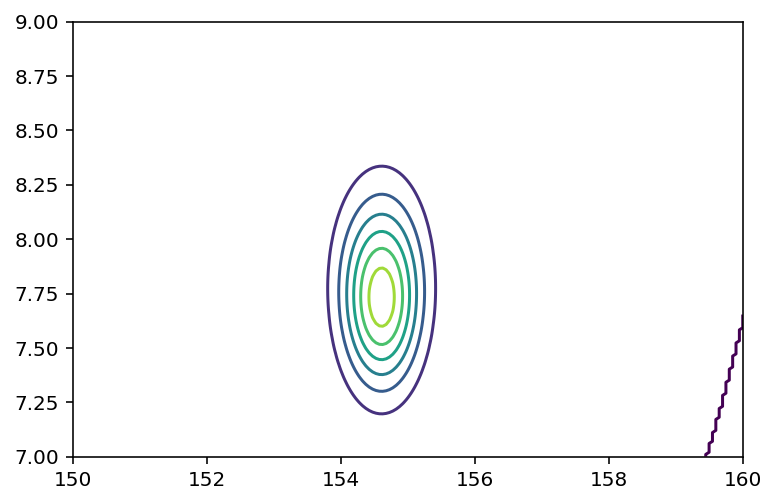

In [26]:
reshaped_joint_prob = tf.reshape(joint_prob, shape=(200,200))
plt.contour(*mesh, reshaped_joint_prob);

##### Code 4.18

Here we are plotting a heatmap instead of contour plot

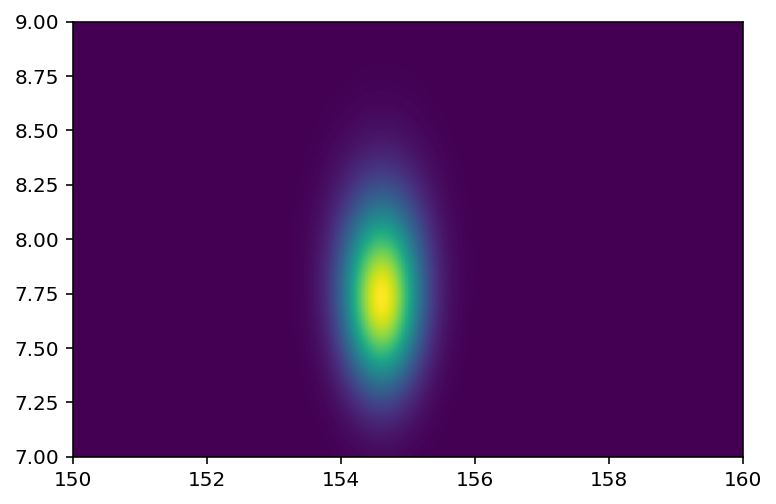

In [27]:
plt.imshow(reshaped_joint_prob,  origin="lower", extent=(150, 160, 7, 9), aspect="auto");

### 4.3.4 Sampling from the posterior

##### Code 4.19 & 4.20

We are at point of now **Sampling from the Posterior**

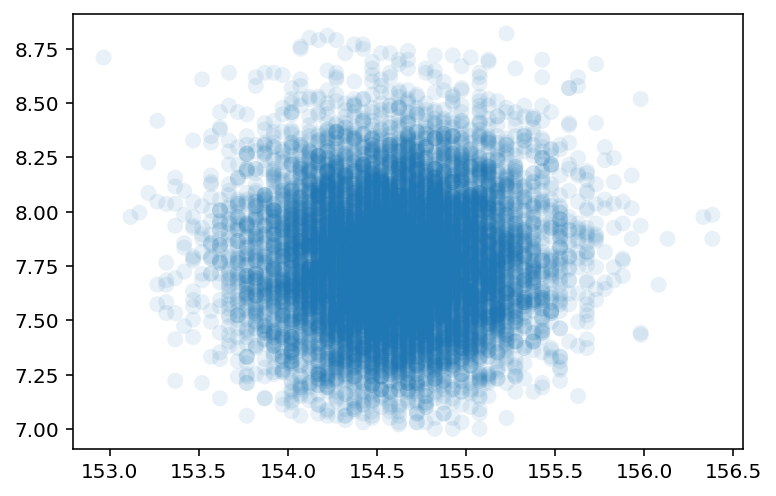

In [28]:
# This is a trick to sample row numbers randomly with the help of Categorical distribution
sample_rows = tfd.Categorical(probs=(joint_prob/tf.reduce_sum(joint_prob))).sample(100_00)

mu = tf.reshape(mesh[0], -1)
sigma = tf.reshape(mesh[1], -1)

# We are sampling 2 parameters here from the selected rows
sample_mu = mu.numpy()[sample_rows]
sample_sigma = sigma.numpy()[sample_rows]


plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none");

##### Code 4.21

Time to summarize/describe the distribution of confidence in each combination of $\mu$ & $\sigma$ using the samples.

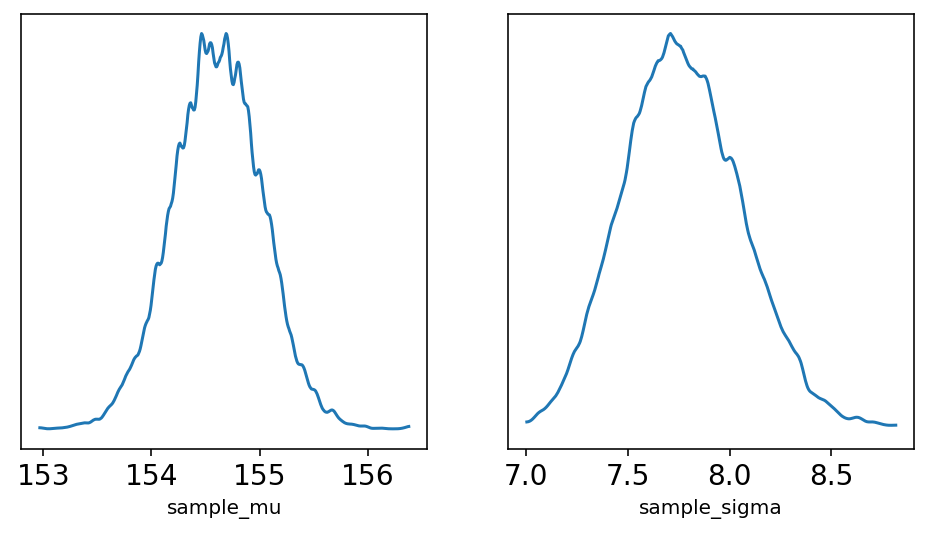

In [29]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu')
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma')
ax[1].set_yticks([]);

As should be clear from the plot, the densities here are very close *normal distribution*. As sample size increases, posterior densities show this behavior. 

Pay attention to sample_sigma, density of it has a **longer right-hand tail**. Author mentions here that this condition is very common for standard deviation parameters. No explanation about it at this point of time.

##### Code 4.22

Now we want to summarize the widths of these densities with **posterior compatibility intervals**

In [30]:
print("sample_mu -", az.hdi(sample_mu))
print("sample_sigma -", az.hdi(sample_sigma))

sample_mu - [153.7186  155.27638]
sample_sigma - [7.231156 8.316583]


##### Code 4.23 & Code 4.24

Author now wants to use Quadratic approximation but he wants to make a point about using it and impact of $\sigma$ on this approximation.

Here the above analysis of the height data is repeated but with only a fraction of original data. The reasoning behind is to demonstrate that, in principle, the posterior is not always Gaussian in shape.

Author explains that for a Guassian $\mu$ & Gaussian likelihood the shape is always Gaussian irrespective of the sample size but it is the $\sigma$ that causes problems.

In [31]:
# We just get 20 samples for now and repeat our exercise
d3 = d2.height.sample(n=20)

In [32]:
mesh2, joint_prob2 = grid_approximation(
    tf.cast(d3.values, dtype=tf.float32), 
    mu_start=150.,
    mu_stop=170.,
    sigma_start=4.,
    sigma_stop=20.,
)

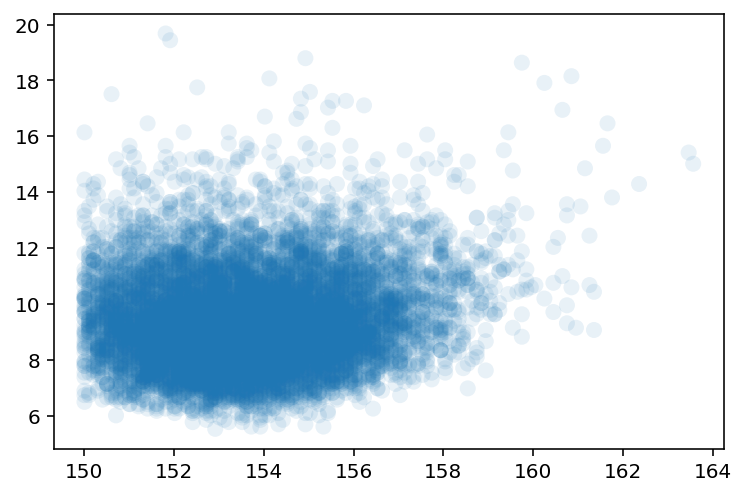

In [33]:
sample2_rows = tfd.Categorical(probs=(joint_prob2/tf.reduce_sum(joint_prob2))).sample(100_00)

mu2 = tf.reshape(mesh2[0], -1)
sigma2 = tf.reshape(mesh2[1], -1)

sample2_mu = mu2.numpy()[sample2_rows]
sample2_sigma = sigma2.numpy()[sample2_rows]

plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none");

##### Code 4.25

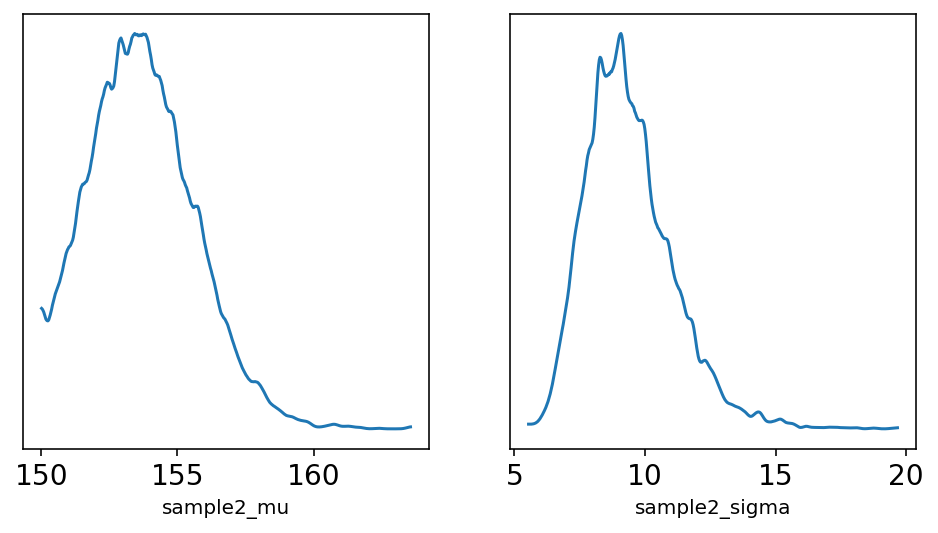

In [34]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample2_mu, ax=ax[0])
ax[0].set_xlabel('sample2_mu')
ax[0].set_yticks([])
az.plot_kde(sample2_sigma, ax=ax[1])
ax[1].set_xlabel('sample2_sigma')
ax[1].set_yticks([]);

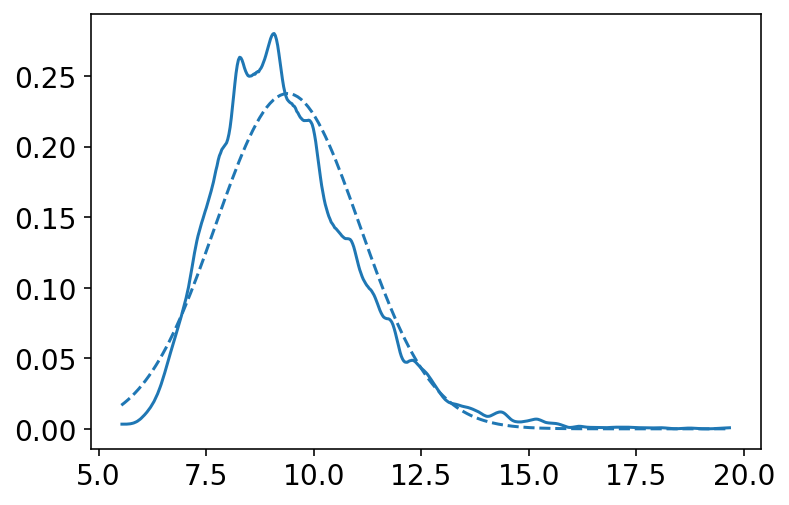

In [35]:
az.plot_kde(sample2_sigma)
x = np.sort(sample2_sigma)
plt.plot(x, np.exp(tfd.Normal(loc=np.mean(x), scale=np.std(x)).log_prob(x)), "--");

### 4.3.5 Finding the posterior distribution using quap

##### Code 4.26

We will reload our data frame and start to use quadratic approximiation now

In [36]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
print(d.head())

d2 = d[d.age > 18]

d2

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


##### Code 4.27

We are now ready to define our model using tensorflow probability.


There are few ways to define a model using tfp, I am going to use a variant
of JointSequential that uses Coroutines (generator) based syntax. However, you can always
define as a plain function and return log probs yourself. An example of plain function that would be 

```python
def joint_log_prob_model(mu, sigma, data):
  mu_dist = tfd.Normal(loc=178., scale=20.)
  sigma_dist = tfd.Uniform(low=0., high=50.)
  height_dist = tfd.Normal(loc=mu, scale=sigma)
  
  return (
      mu_dist.log_prob(mu) +
      sigma_dist.log_prob(sigma) +           
      tf.reduce_sum(height_dist.log_prob(data)) 
  )
```

In [37]:
def model_4_1():
    def _generator():
      mu = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_4_1 = model_4_1()

##### Code 4.28

In [38]:
posterior_4_1, trace_4_1 = sample_posterior(
                    jdc_4_1, 
                    observed_data=(d2.height.values,), 
                    params=['mu', 'sigma'])

##### Code 4.29

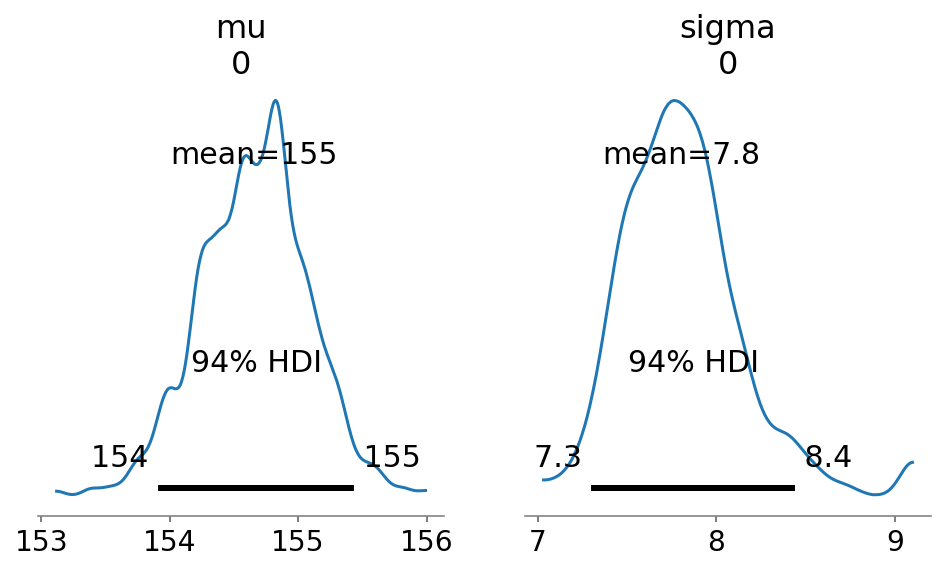

In [39]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_posterior(trace_4_1, var_names=['mu', 'sigma'], ax=ax);

In [40]:
az.summary(trace_4_1, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu[0],154.66,0.42,153.98,155.30
sigma[0],7.80,0.32,7.28,8.22


These numbers shown above provide Gaussian approximations for each parameter’s marginal distribution.

##### Code 4.30

What should be the starting values for the sampling ?

Author recommends that we could use the mean from the dataframe

In [41]:
def use_mean_from_data_as_priors():    
    
    hm = tf.expand_dims(tf.constant([d2.height.mean(), d2.height.mean()], dtype=tf.float32), axis=-1)
    hs = tf.expand_dims(tf.constant([d2.height.std(), d2.height.std()], dtype=tf.float32), axis=-1)

    init_state = [
        hm,
        hs
    ]
    
    results = sample_posterior(
                    jdc_4_1, 
                    observed_data=(d2.height.values,), 
                    init_state=init_state,
                    params=['mu', 'sigma'])    
    
use_mean_from_data_as_priors()

##### Code 4.31

In [42]:
def model_4_2():
    def _generator():
      mu = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=0.1), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_4_2 = model_4_2()

posterior_4_2, trace_4_2 = sample_posterior(
                                jdc_4_2, 
                                observed_data=(d2.height.values,), 
                                params=['mu', 'sigma'])

az.summary(trace_4_2, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu[0],177.87,0.10,177.73,178.04
sigma[0],24.53,0.92,22.99,25.85


Taken verbatim from the book :

Notice that the estimate for μ has hardly moved off the prior. The prior was very concentrated around 178. So this is not surprising. But also notice that the estimate for σ has changed quite a lot, even though we didn’t change its prior at all. Once the golem is certain that the mean is near 178—as the prior insists—then the golem has to estimate σ conditional on that fact. This results in a different posterior for σ, even though all we changed is prior information about the other parameter.

##### Code 4.32


Now this approximation of posterior is multi-dimension where $\mu$ and $\sigma$ are contributing a dimension each. In other words, we have a multi-dimensional gaussian distribution

Since it is multi-dimensional, let's see the covariances between the parameters

In [43]:
# using only first chain
sample_mu, sample_sigma = posterior_4_1["mu"][0], posterior_4_1["sigma"][0]
sample_mu, sample_sigma = tf.squeeze(sample_mu), tf.squeeze(sample_sigma)
vcov = tfp.stats.covariance(tf.stack([sample_mu, sample_sigma], axis=1))
vcov

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.17729352, 0.00521   ],
       [0.00521   , 0.06563617]], dtype=float32)>

##### Code 4.33

In [44]:
diag_part = tf.linalg.diag_part(vcov)
print(diag_part)
print(vcov / tf.sqrt(tf.tensordot(diag_part, diag_part, axes=0)))

tf.Tensor([0.17729352 0.06563617], shape=(2,), dtype=float32)
tf.Tensor(
[[1.         0.04829695]
 [0.04829695 1.        ]], shape=(2, 2), dtype=float32)


##### Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [45]:
sample_sigma[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7.3088455, 7.840941 , 7.840941 , 8.069336 , 8.069336 , 8.069336 ,
       7.7020855, 7.5962734, 7.5962734, 7.616722 ], dtype=float32)>

##### Code 4.35

In [46]:
az.summary({
    'mu' : sample_mu,
    'sigma' : sample_sigma
}, round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.64,0.42,153.93,155.26
sigma,7.75,0.26,7.37,8.14


##### Code 4.36

In [47]:
samples_flat = np.stack([sample_mu, sample_sigma], axis=0)
mu_mean = np.mean(sample_mu, dtype=np.float64)
sigma_mean = np.mean(sample_sigma, dtype=np.float64)
cov = np.cov(samples_flat)

mu_mean, sigma_mean, cov

(154.6415894470215,
 7.750794026374817,
 array([[0.17764881, 0.00522044],
        [0.00522044, 0.06576769]]))

In [48]:
mvn = tfd.MultivariateNormalFullCovariance(
    loc=[mu_mean, sigma_mean],
    covariance_matrix=cov)

mvn.sample(1000)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


<tf.Tensor: shape=(1000, 2), dtype=float64, numpy=
array([[154.36303928,   7.98448626],
       [154.88101167,   7.5264936 ],
       [154.46743425,   7.86625362],
       ...,
       [155.30770615,   7.84671145],
       [154.76260977,   7.69925495],
       [154.54721352,   7.59212295]])>

## 4.4 Linear prediction

##### Code 4.37

So now let’s look at how height in these Kalahari foragers (the outcome variable) covaries with weight (the predictor variable).

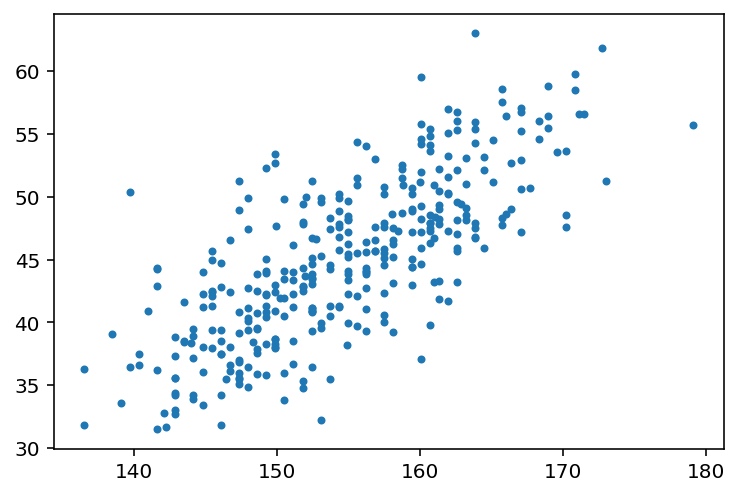

In [49]:
plt.plot(d2.height, d2.weight, ".");

The plot clearly shows a relationship between weight and height.

### 4.4.1 The linear model strategy

##### Code 4.38, & 4.39 


This snippet is in the section titled - "The linear model strategy". The section is a master piece and clearly explains the conceptual meaning of *intercept* and *slope* in linear models. Read the section thoroughly with a cup of tea and it will make your day !.

In brief, we have now started to model the relation between height & weight formally and the strategy is formally Linear Model and process is called Linear Regression. 

Here is the description of the model -

$h_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta(x_i - \bar{x})$   

$\alpha \sim Normal(178,20)$       

$\beta \sim Normal(0,10)$          

$\sigma \sim Uniform(0,50)$        


where, $h_i$ is the likelhood, $\mu_i$ is the linear model and rest are the priors

Important thing to note is that $h_i$ has a subscript $i$, which means that *the mean depends upon the row*

$\mu_i$ is also called a **Deterministic Variable** as given the values of other **Stochastic Variables** we are certain about the values it would take !

In [50]:
# We are simulating a bunch of lines here 
tf.compat.v1.random.set_random_seed(2971)

N = 100

a = tfd.Normal(loc=178.0, scale=20.0).sample(N)
b = tfd.Normal(loc=0., scale=10.0).sample(N)

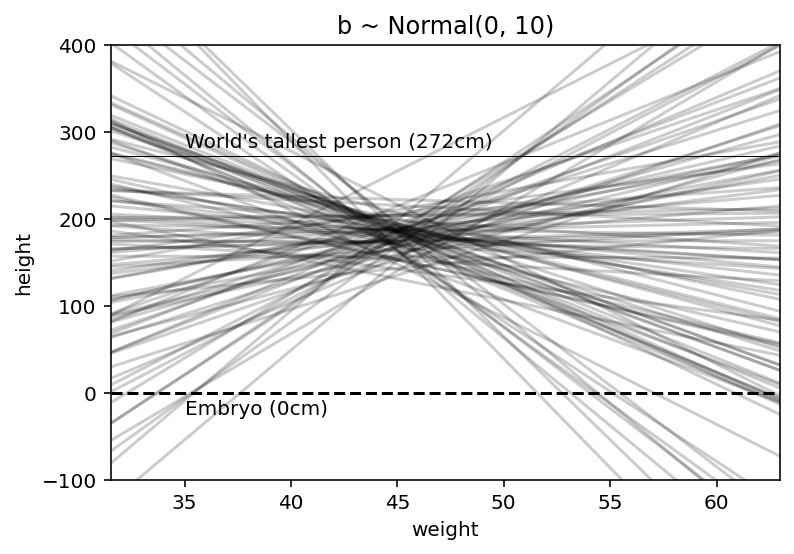

In [51]:
# And then plotting them

plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);
    
plt.text(x=35, y=282, s="World's tallest person (272cm)")
plt.text(x=35, y=-25, s="Embryo (0cm)");

'---' represents a zero - no one is shorter than this & also is shown the line for world's tallest person.

Clearly, the lines are showing unnatural relationships therefore befoe we have even see the data, this is a bad model. Again prior predictive checks are coming in handy !

##### Code 4.40

We use some common sense here, we know that average height increases with average weight (to some extent and to a certain point) therefore we must restrict it to positive values only. 

Earlier we used Normal distribution for beta but a better one is LogNormal

$\beta \sim LogNormal(0,1)$

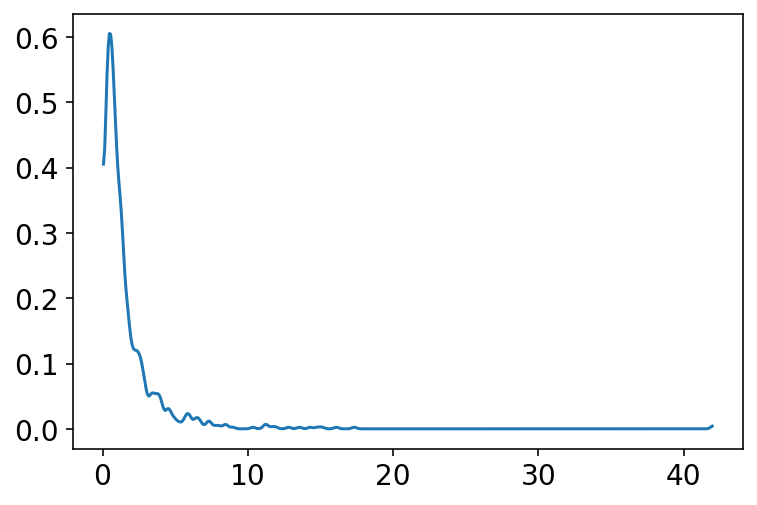

In [52]:
b = tfd.LogNormal(loc=0., scale=1.).sample(1000)
az.plot_kde(b.numpy());

##### Code 4.41

Doing the prior predictive check again where $\beta$ is LogNormal

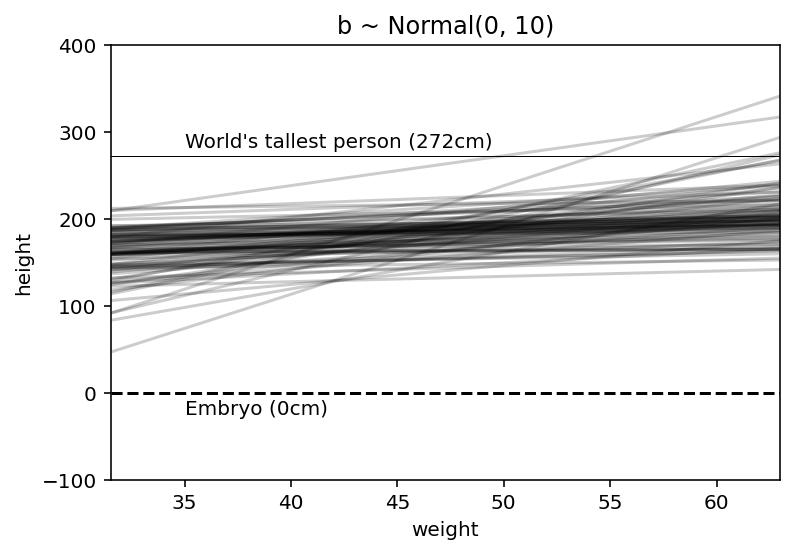

In [53]:
# We are simulating a bunch of lines here 
tf.compat.v1.random.set_random_seed(2971)

a = tfd.Normal(loc=178.0, scale=20.0).sample(100)
b = tfd.LogNormal(loc=0., scale=1.0).sample(100)

plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);
    
plt.text(x=35, y=282, s="World's tallest person (272cm)")
plt.text(x=35, y=-25, s="Embryo (0cm)");

Now this is much sensible plot; nearly all lines in the joint prior for $\alpha$ & $\beta$ are now in human reason.

### 4.4.2 Finding the posterior distribution

##### Code 4.42

Time to build the model again with all the new things we have discovered and updates discussed above

In [54]:
# read the data set
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d2 = d[d.age > 18]

# define the average height
x_bar = d2.weight.mean()

def model_4_3(weight_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      beta = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=1.0), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      mu =  alpha + beta * (weight_data - x_bar)    
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_4_3 = model_4_3(d2.weight.values)

posterior_4_3, trace_4_3 = sample_posterior(
                                jdc_4_3, 
                                observed_data=(d2.height.values,), 
                                params=['alpha', 'beta', 'sigma'])

az.summary(trace_4_3, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],154.67,0.28,154.19,155.08
beta[0],0.91,0.04,0.84,0.97
sigma[0],5.15,0.19,4.83,5.44


##### Code 4.43 

Here the author talks about using log($\beta$) instead of just $\beta$ and says that the results will be same. 

But I did not find/understand the reason for it.

In [55]:
def model_4_3b(weight_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      beta = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      exp_value = tf.cast(tf.exp(beta), dtype=tf.float32)
    
      mu =  alpha + exp_value * (weight_data - x_bar)    
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_4_3b = model_4_3b(d2.weight.values)

posterior_4_3b, trace_4_3b = sample_posterior(
                                    jdc_4_3b, 
                                    observed_data=(d2.height.values,), 
                                    params=['alpha', 'beta', 'sigma'])

### 4.4.3 Interpreting the posterior distribution

##### Code 4.44

In [56]:
az.summary(trace_4_3b, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],154.65,0.26,154.26,155.09
beta[0],-0.10,0.05,-0.17,-0.02
sigma[0],5.14,0.19,4.82,5.43


##### Code 4.45

In [57]:
sample_alpha = tf.squeeze(posterior_4_3["alpha"][0])
sample_beta  = tf.squeeze(posterior_4_3["beta"][0])
sample_sigma = tf.squeeze(posterior_4_3["sigma"][0])

samples_flat = tf.stack([sample_alpha, sample_beta, sample_sigma], axis=0)

# TODO:
# not able to get the desired result with tfp.stats.covariance
cov = np.cov(samples_flat)

alpha_mean = tf.reduce_mean(sample_alpha)
beta_mean  = tf.reduce_mean(sample_beta)
sigma_mean = tf.reduce_mean(sample_sigma)

alpha_mean, beta_mean, sigma_mean, cov

(<tf.Tensor: shape=(), dtype=float32, numpy=154.69965>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.90452254>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.1466722>,
 array([[0.07012054, 0.00016082, 0.00192138],
        [0.00016082, 0.0017419 , 0.00056733],
        [0.00192138, 0.00056733, 0.03548652]]))

In [58]:
np.round(cov,3)

array([[0.07 , 0.   , 0.002],
       [0.   , 0.002, 0.001],
       [0.002, 0.001, 0.035]])

We see very little covariance among the parameters in this case. This lack of covariance among the parameters results from something called **Centering**

#### 4.4.3.2 Plotting posterior inference against the data

##### Code 4.46

This snippet appears in the section titled **Plotting posterior inference against the data**. 

Author examplins that plotting is extremely useful in see when key observations or patterns in the plotted data are not close to the model's pediction.

In this snippet, we start with the simple version of the task (i.e. plotting) by superimposing the posterior mean values over the height & weight data. Later more and more information to prediction plots will be added until the entire posterior distribution is covered.


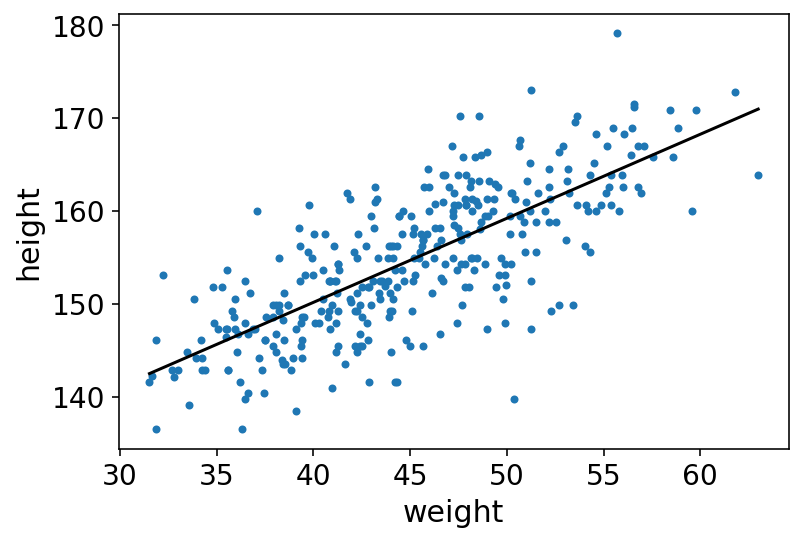

In [59]:
# Let's try just the raw data and a single line

# Raw data is shown using the dots
# The line shows the model that makes use of average values of alpha and beta

az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))

a_map = tf.reduce_mean(sample_alpha)
b_map = tf.reduce_mean(sample_beta)
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k");

Now above line is a good line, quite plausible line (model) actually. However, we must not forget that there are an infinite number of other highly plausible lines near it. So we would next try to get them as well !

##### Code 4.47 TODO : Add notes

In [60]:
# Looking at few values/samples from our posterior
summary_dict = {
    'alpha' : sample_alpha, 
    'beta'  : sample_beta,
    'sigma' : sample_sigma
}   
pd.DataFrame.from_dict(summary_dict).head(5)

,alpha,beta,sigma
0,155.140060,0.845223,5.224426
1,155.140060,0.845223,5.224426
2,155.140060,0.845223,5.224426
3,154.846619,0.852842,5.428785
4,154.899963,0.834662,5.161688


##### Code 4.48

In [61]:
N = 10
dN = d2[:N]

jdc_4_N = model_4_3(dN.weight.values)

posterior_4_N, trace_4_N = sample_posterior(jdc_4_N, 
                              observed_data=(dN.height.values,), 
                              params=['alpha', 'beta', 'sigma'])

az.summary(trace_4_N, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],152.26,2.03,148.44,154.95
beta[0],0.90,0.23,0.59,1.28
sigma[0],6.30,2.42,3.40,8.93


##### Code 4.49  TODO : plot with more data i.e. N = 10,50,150,352

Now let's plot 20 of these lines, to see what the uncertainity looks like

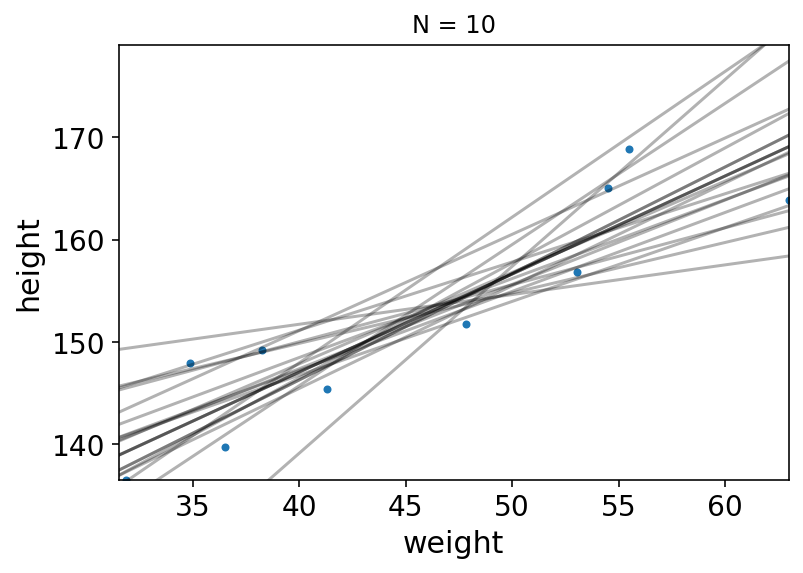

In [62]:
summary_dict_n = {
    'alpha' : tf.squeeze(trace_4_N.posterior['alpha'].values[0]),
    'beta'  : tf.squeeze(trace_4_N.posterior['beta'].values[0]),
    'sigma' : tf.squeeze(trace_4_N.posterior['sigma'].values[0]),
}   

twenty_random_samples = pd.DataFrame.from_dict(summary_dict_n).sample(20).to_dict('list')

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(xlim=(d2.weight.min(), d2.weight.max()),
       ylim=(d2.height.min(), d2.height.max()), title="N = {}".format(N))

# plot the lines, with transparency
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, twenty_random_samples["alpha"][i] + twenty_random_samples["beta"][i] * (x - dN.weight.mean()),
             "k", alpha=0.3)

##### Code 4.50 & 4.51

Here we focus on a single weight value of 50 KG.



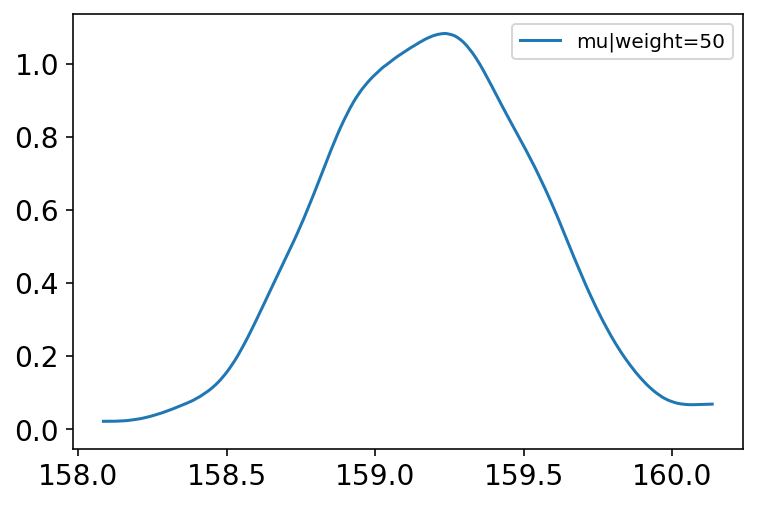

In [63]:
mu_at_50 = summary_dict["alpha"] + summary_dict["beta"] * ( 50 - x_bar )

az.plot_kde(mu_at_50.numpy(), label="mu|weight=50");

##### Code 4.52


In [64]:
az.hdi(mu_at_50.numpy())

array([158.60243, 159.76747], dtype=float32)

##### Code 4.53 & 4.54 & 4.55

Above we picked the weight=50 but we need to repeat the above calculation for every weight value and not just 50Kg.

The rethinking R package has a *link* method that does it automatically but here we will do it manually

In [65]:
weight_seq = np.arange(25, 71)
n_samples = len(summary_dict['alpha'])
mu_pred = np.zeros((len(weight_seq), n_samples))
for i, w in enumerate(weight_seq):
    mu_pred[i] = summary_dict['alpha'] + summary_dict['beta'] * (
        w - d2.weight.mean()
    )

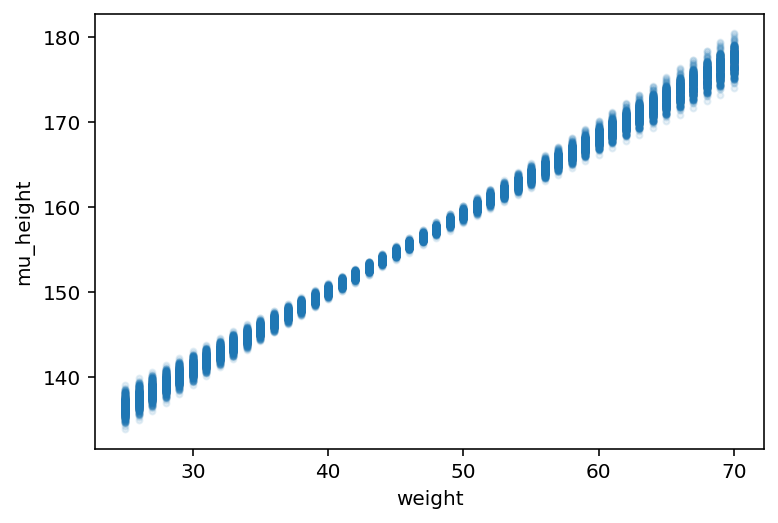

In [66]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("mu_height");

There are 46 columns in $\mu$ because we fed it 46 different values of weight. 

##### Code 4.56

Now we want to summarize the distribution for each weight value

In [67]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hdi(mu_pred.T)

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


##### Code 4.57

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


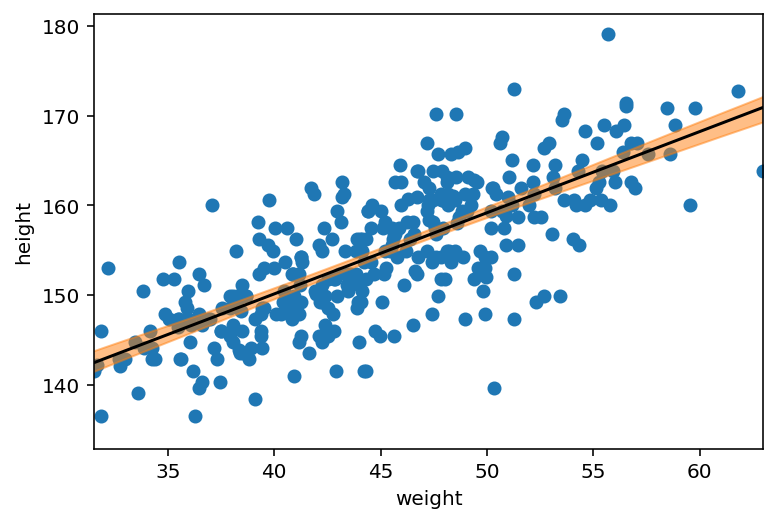

In [68]:
_, axes = plt.subplots(1,1)       
axes.scatter(d2.weight, d2.height)
axes.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());
az.plot_hdi(weight_seq, mu_pred.T, ax=axes);

##### Code 4.58

This snippet is showing the source code for the *link* function of R package. It is almost
equivalent to what you see above in Code 4.53 until 4.56

##### Code 4.59


The task here now is to generate 89% prediction interval for actual heights, not just the average height $\mu$

i.e

$h_i \sim Normal(\mu_i, \sigma)$

So now we need to include $\sigma$ somwhow.

The algo is quite  straightfoward here -

* For any unique weight value, sample from Gaussian distribution with correct mean $\mu$ for that weight
* Use the correct value of $\sigma$ sampled from the same posterior distribution. 

If we do above for every sample from posterior, for every weight value of interest then we will end up with a collection of simulated heights



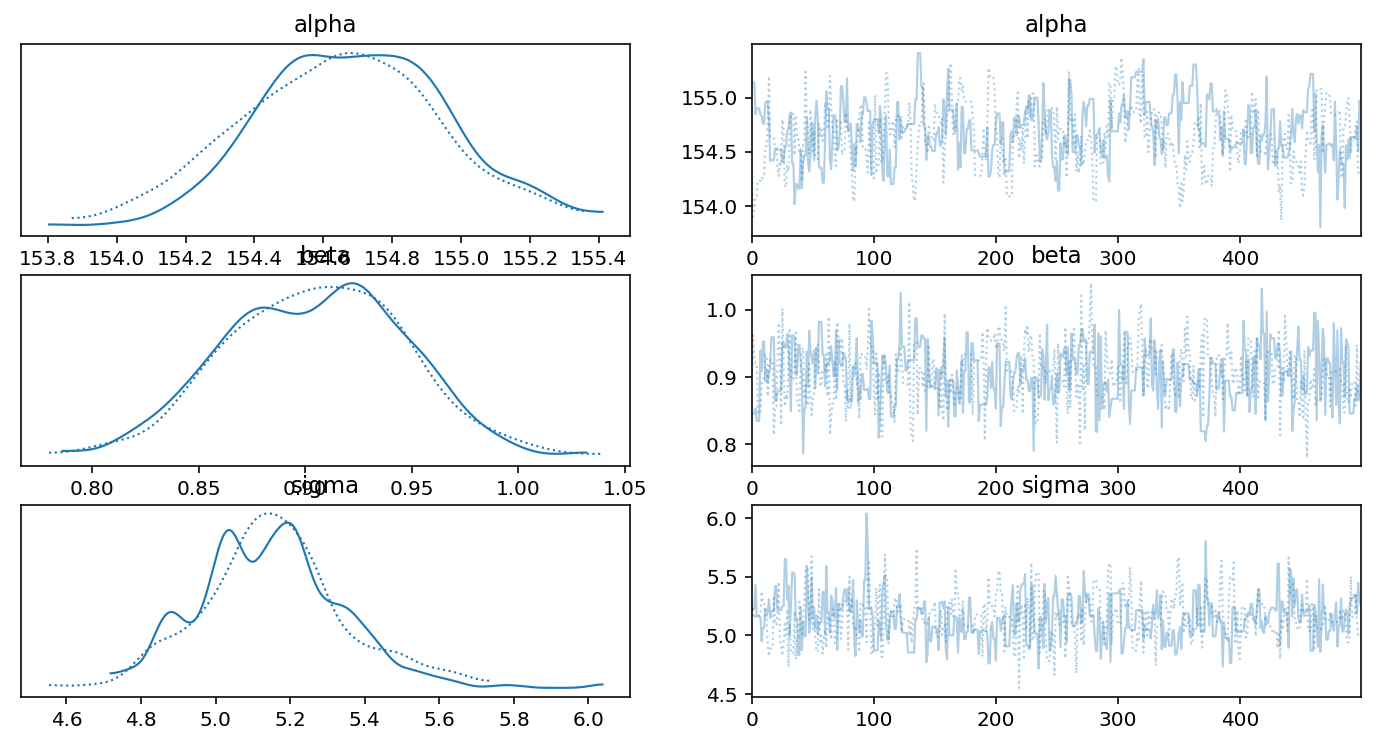

In [69]:
az.plot_trace(trace_4_3, compact=True);

In [70]:
# In this cell we are using posterior samples to computer
# the height for various weights

# only taking data from chain 1
sample_alpha = posterior_4_3["alpha"][0]
sample_beta  = posterior_4_3["beta"][0]
sample_sigma = posterior_4_3["sigma"][0]

weight_seq = np.arange(25, 71)

jdc_4_3_weight_seq = model_4_3(weight_seq)

# we are going to essentially sample height for these new weight sequences
# conditioned on our trace
_, _, _, sim_height = jdc_4_3_weight_seq.sample(value=[
    sample_alpha,
    sample_beta, 
    sample_sigma,
    None
])

##### Code 4.60

In [71]:
height_PI = tfp.stats.percentile(sim_height, q=(5.5, 94.5), axis=0)

##### Code 4.61

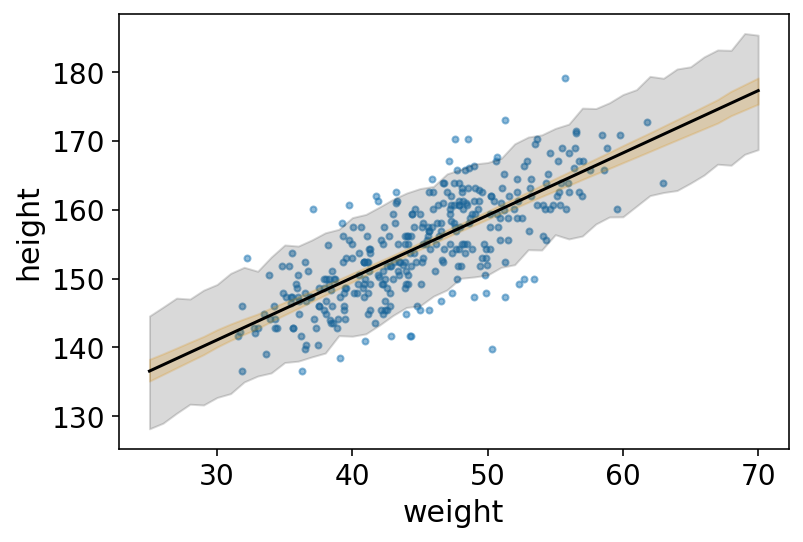

In [72]:
# plot raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.5},
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_hpd.T[0], mu_hpd.T[1], color="orange", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(
    weight_seq,
    height_PI[0],
    height_PI[1],
    color="k",
    alpha=0.15,
);

##### Code 4.62

This snippet is re-running above but with more samples to see that the shaded boundary will smooth out some more

##### Code 4.63

This snippet here is showing the internals of Author's *sim* function in *R*. 

I have it implemented (naive version) in cell of 4.59

This snippet here is showing the internals of Author's *sim* function in *R*

## 4.5 Curves from lines

### 4.5.1 Polynomial regression

##### Code 4.64

Here we start to look at polynomial regression and splines.

Polynomial Regression is the first one. It helps to build curved associations. This time we will use full data instead of just adults

In [73]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)

d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


##### Code 4.65

Most common polynomial regression is a parabolic (degree 2) model of the mean.

$\mu_i \sim \alpha + \beta_1x_i + \beta_2x_i^2$


**Standardization** is important in general but it becomes even more important for polynomials. Think what happens when you square or cube big numbers. They will create large variations.



In [74]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std ** 2

def model_4_5(weight_data_s, weight_data_s2):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      beta1 = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=1.0), sample_shape=1))
      beta2 = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))        
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      mu =  alpha + beta1 * weight_data_s + beta2 * weight_data_s2  
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_4_5 = model_4_5(d.weight_std.values, d.weight_std2.values)

posterior_4_5, trace_4_5 = sample_posterior(
                                    jdc_4_5,
                                    observed_data=(d.height.values,),
                                    params=['alpha', 'beta1', 'beta2', 'sigma'])

##### Code 4.66

In [75]:
az.summary(trace_4_5, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],172.02,25.50,146.51,197.51
beta1[0],10.88,10.21,0.68,21.11
beta2[0],-4.05,3.83,-7.95,-0.22
sigma[0],3.36,2.39,0.97,5.80


##### Code 4.67

In [76]:
sample_alpha = posterior_4_5["alpha"][0]
sample_beta1 = posterior_4_5["beta1"][0]
sample_beta2 = posterior_4_5["beta2"][0]
sample_sigma = posterior_4_5["sigma"][0]

weight_seq = tf.linspace(start=-2.2, stop=2, num=30)
weight_seq = tf.cast(weight_seq, dtype=tf.float32)

jdc_4_5_weight_seq = model_4_5(weight_seq, weight_seq**2)

# we are going to essentially sample height for these new weight sequences
# conditioned on our trace
ds, samples = jdc_4_5_weight_seq.sample_distributions(value=[
    sample_alpha,
    sample_beta1,
    sample_beta2,
    sample_sigma,
    None
])

# get our height samples conditioned on the trace
sim_height = samples[-1]

# get the distribution object for the liklihood
likelihood = ds[-1].distribution

In [77]:
# getting the loc which is mu
mu_pred = likelihood.loc
mu_mean = tf.reduce_mean(mu_pred, 0)

mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)    
height_PI = tfp.stats.percentile(sim_height, q=(5.5, 94.5), axis=0)

##### Code 4.68

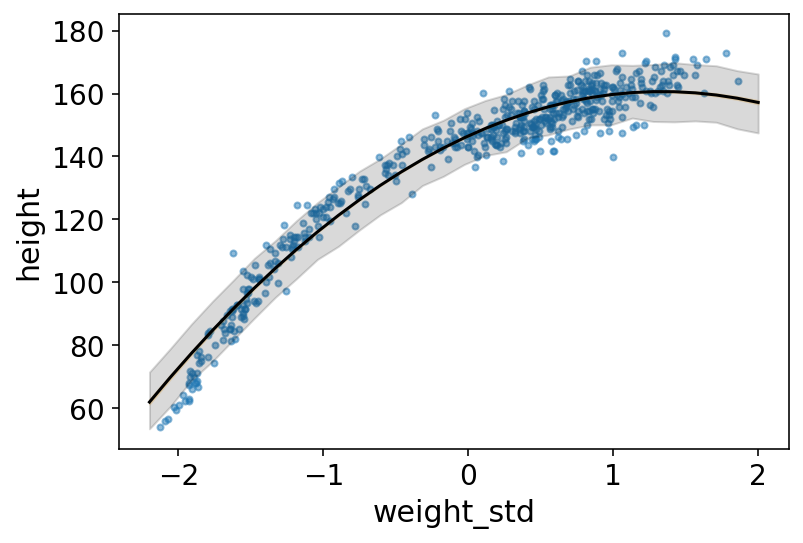

In [78]:
# plot raw data
az.plot_pair(
    d[["weight_std", "height"]].to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.5},
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="orange", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(
    weight_seq,
    height_PI[0],
    height_PI[1],
    color="k",
    alpha=0.15,
 );

##### Code 4.69

In [79]:
d["weight_std3"] = d.weight_std ** 3


def model_4_6(weight_data_s, weight_data_s2, weight_data_s3):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      beta1 = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=1.0), sample_shape=1))
      beta2 = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))        
      beta3 = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))        
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      mu =  alpha + beta1 * weight_data_s + beta2 * weight_data_s2  + beta3 * weight_data_s3
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_4_6 = model_4_6(d.weight_std.values, d.weight_std2.values, d.weight_std3.values)

posterior_4_6, trace_4_6 = sample_posterior(jdc_4_6, 
                                  observed_data=(d.height.values,),
                                  params=['alpha', 'beta1', 'beta2', 'beta3', 'sigma'])


##### Code 4.70 & 4.71

In [80]:
sample_alpha = posterior_4_6["alpha"][0]
sample_beta1 = posterior_4_6["beta1"][0]
sample_beta2 = posterior_4_6["beta2"][0]
sample_beta3 = posterior_4_6["beta3"][0]
sample_sigma = posterior_4_6["sigma"][0]

weight_seq = tf.linspace(start=-2.2, stop=2, num=30)
weight_seq = tf.cast(weight_seq, dtype=tf.float32)

jdc_4_6_weight_seq = model_4_6(weight_seq, weight_seq**2, weight_seq**3)

# we are going to essentially sample height for these new weight sequences
# conditioned on our trace
ds, samples = jdc_4_6_weight_seq.sample_distributions(value=[
    sample_alpha, 
    sample_beta1, 
    sample_beta2, 
    sample_beta3, 
    sample_sigma, 
    None
])

# get our height samples conditioned on the trace
sim_height = samples[-1]

# get the distribution object for the liklihood
liklihood = ds[-1].distribution

sim_height.shape

TensorShape([500, 30])

In [81]:
# getting the loc which is mu
mu_pred = liklihood.loc

mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)    
height_PI = tfp.stats.percentile(sim_height, q=(5.5, 94.5), axis=0)

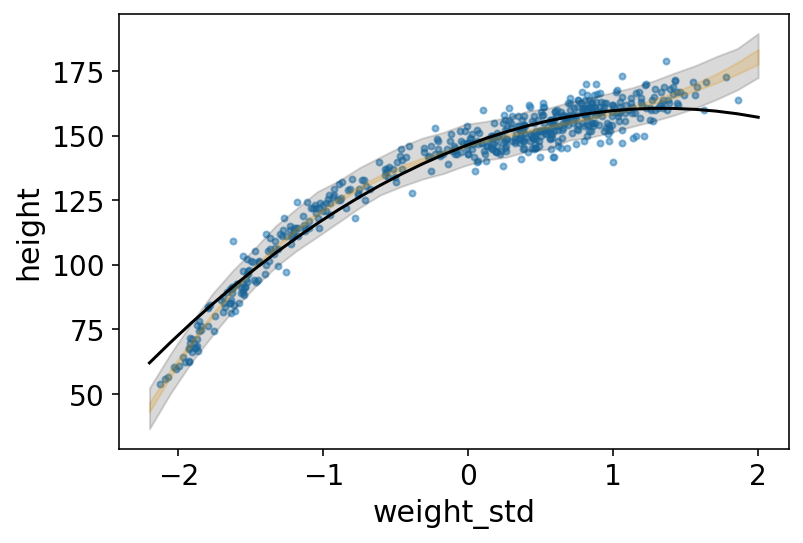

In [82]:
# plot raw data
az.plot_pair(
    d[["weight_std", "height"]].to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.5},
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="orange", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(
    weight_seq,
    height_PI[0],
    height_PI[1],
    color="k",
    alpha=0.15,
);

### 4.5.2 Splines

##### Code 4.72

In [83]:
d = pd.read_csv(CHERRY_BLOSSOMS_DATASET_PATH, sep=';', header=0)

d.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [84]:
az.summary(d.to_dict(orient="list"), kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
year,1408.0,350.885,801.00,1882.0
doy,NaN,NaN,86.00,NaN
temp,NaN,NaN,5.06,NaN
temp_upper,NaN,NaN,5.78,NaN
temp_lower,NaN,NaN,3.60,NaN


##### Code 4.73


Knots are just values of the year that serve as pivots for our spline. We will be using 15 of these pivots.

Now question is where should we place these knots ?. They can be put anywhere in principle. Finding the locations of them can be considered part of modelling (... so kind of like hyperparameters).

Here we are placing them at different evenly spaced quantiles of the predictor variable (i.e year). 


In [85]:
d2 = d[d.doy.notna()]  # not NaN cases on temp
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

# notice that there are 15 evenly spaced dates ()
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

##### Code 4.74


Next we need to decide on the polynomial degree. This determines how basis functions combine. 

Degree 1 => 2 Basis functions combine at each point
Degree 2 => 3 Basis functions combine at each point

`scipy` provides an implementation for constructing the BSplines given knots and degree of freedom.

Below we are using degree 3 (see the parameter `k` of `BSpline`)

In [86]:
knots = np.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, np.identity(num_knots + 2), k=3)(d2.year.values)

In [87]:
B.shape

(827, 17)

##### Code 4.75

Here we are plotting the basis functions. This means plot each column agaist year.

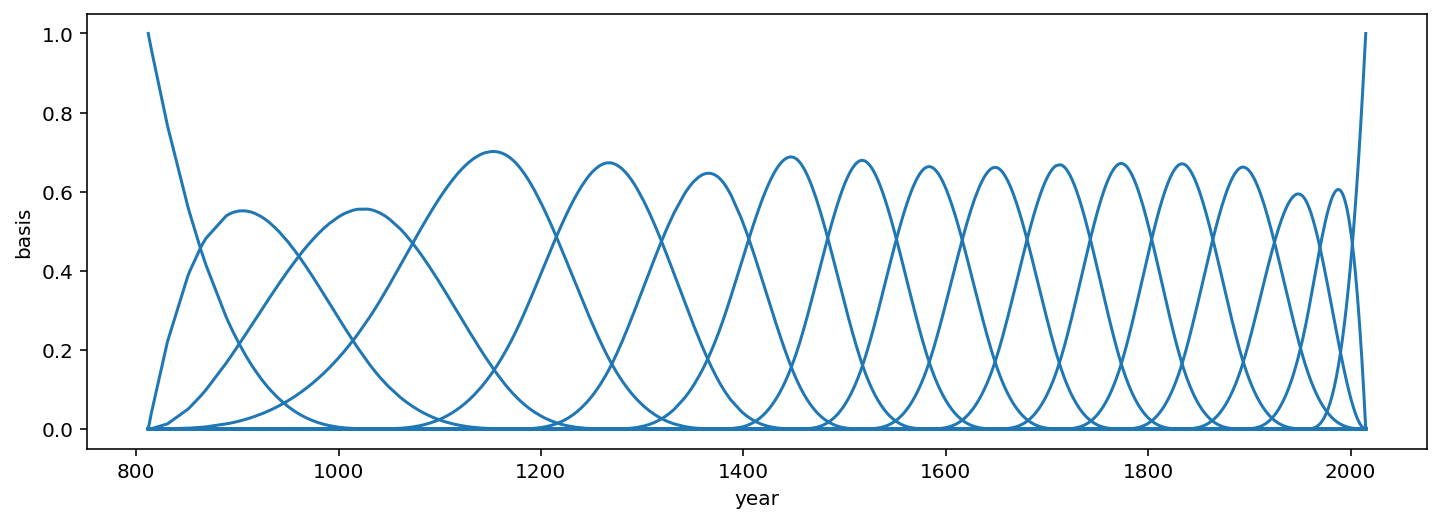

In [88]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(d2.year, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

##### Code 4.76

Time to actually define the model. The problem against is that **Linear Regression**. 

Columns in our B matrix will correspond to the variables (the synthetic variables !)

We should always an intercept to capture the average temperature. [See the discussion earlier in the book why and how intercept indicates the average/mean]

In [89]:
def model_4_7():
    alpha = yield Root(tfd.Sample(tfd.Normal(loc=100.0, scale=10.0, name='alpha'), sample_shape=1))
    w = yield Root(tfd.Sample(tfd.Normal(loc=0.0, scale=10.0, name='w'), sample_shape=17))
    sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
    
    B_x = tf.cast(B, dtype=tf.float32)    
    mu = alpha + tf.einsum("ij,...j->...i", B_x, w)     
   
    doy = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name='D'), reinterpreted_batch_ndims=1)
   
jdc_4_7 = tfd.JointDistributionCoroutine(model_4_7, validate_args=False)

alpha_sample, w_sample, sigma_sample, doy_sample = jdc_4_7.sample(2)

alpha_sample, w_sample, sigma_sample

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[100.413025],
        [102.31073 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 17), dtype=float32, numpy=
 array([[ -7.587472 ,   4.6162534,  14.462044 ,  13.757142 ,   8.293284 ,
           6.5996766,  12.812029 ,   2.066179 , -19.096075 ,  12.009245 ,
           4.0620856,  18.011715 ,   0.7482047,  -8.07599  , -24.254963 ,
           5.2645006,   5.9642544],
        [ -8.49531  ,  11.326171 ,  10.874445 ,  -1.0859208,  -1.8048357,
         -12.088249 ,  -1.5450478,  -5.0279374,   9.356149 ,   2.6080098,
          14.687096 , -11.230017 ,  -6.972492 ,  -7.4885106,  -3.548199 ,
           1.3912767,   3.2297919]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.9223893 ],
        [0.01731652]], dtype=float32)>)

In [90]:
init_state = [
    alpha_sample,
    w_sample,
    sigma_sample
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

posterior_4_7, trace_4_7 = sample_posterior(
    jdc_4_7, 
    num_samples=4000, 
    burnin=1000,
    init_state=init_state,
    bijectors=bijectors,
    observed_data=(tf.cast(d2.doy.values, dtype=tf.float32),),
    params=['alpha', 'w', 'sigma'],
)

In [91]:
az.summary(trace_4_7, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],102.90,2.08,100.51,105.19
w[0],-8.34,0.64,-9.51,-7.47
w[1],7.63,2.81,4.08,10.85
w[2],11.09,1.81,8.59,14.10
w[3],5.07,6.41,-2.01,12.21
w[4],2.94,4.17,-1.82,8.11
w[5],-3.13,7.49,-11.08,5.53
w[6],5.50,5.90,-0.69,12.32
w[7],0.59,3.17,-3.75,4.80
w[8],-3.59,11.57,-16.99,9.04


##### Code 4.77 

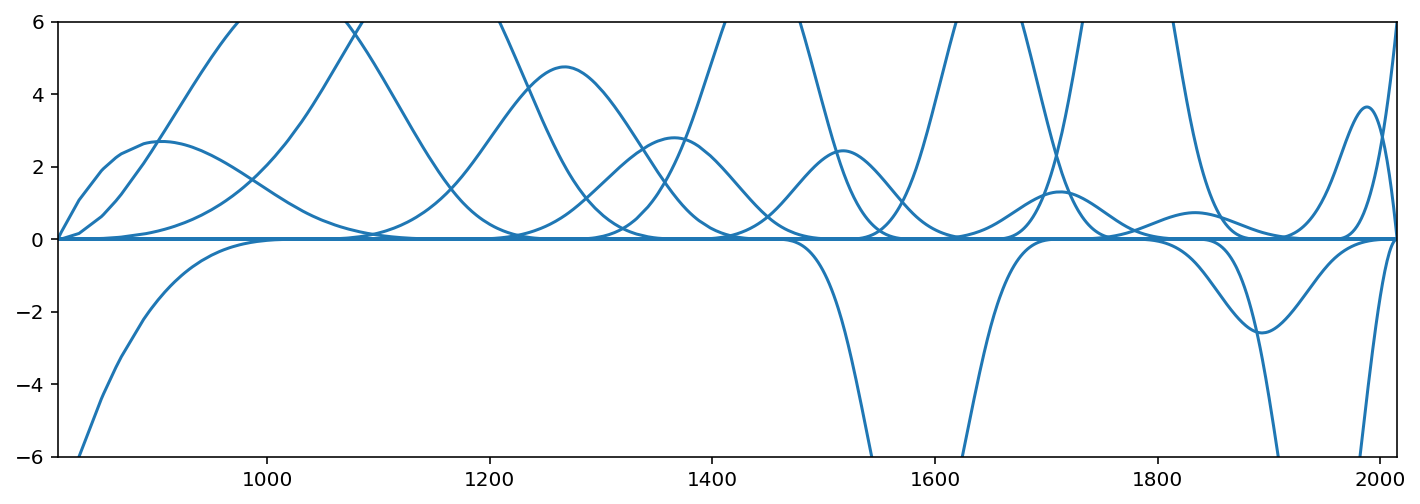

In [92]:
sample_alpha = tf.squeeze(posterior_4_7["alpha"][0])
sample_w     = tf.squeeze(posterior_4_7["w"][0])
sample_sigma = tf.squeeze(posterior_4_7["sigma"][0])

w = sample_w.numpy().mean(0)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(d2.year, (w[i] * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

##### Code 4.78

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


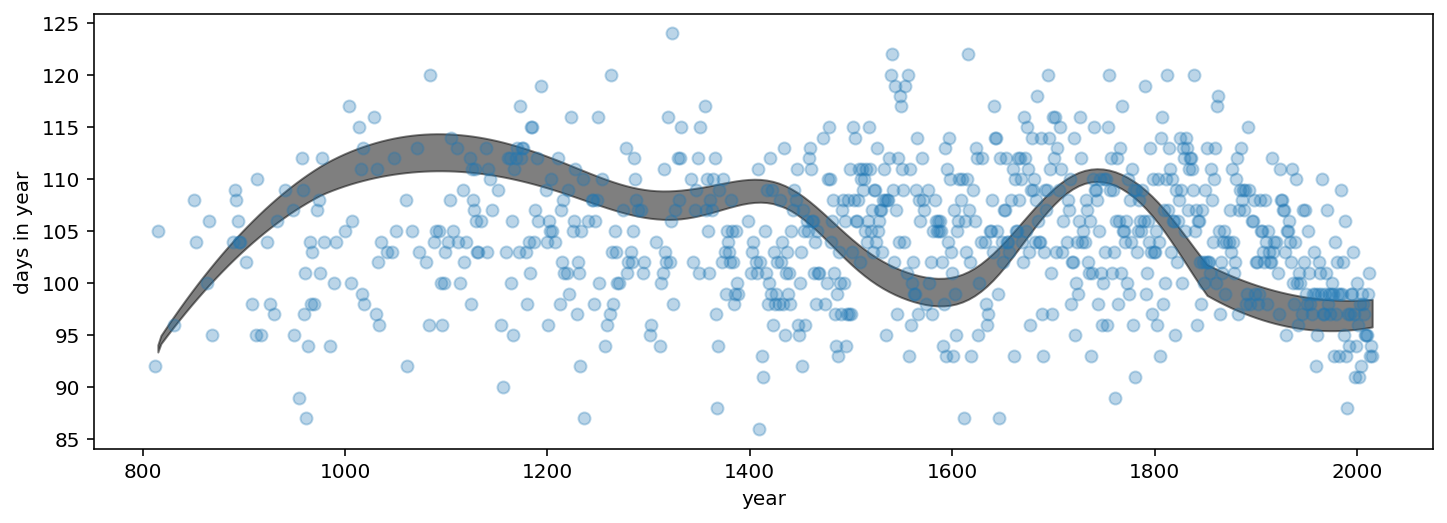

In [93]:
B_x = tf.cast(B, dtype=tf.float32)    
mu_pred = sample_alpha[...,tf.newaxis] + tf.einsum("ij,...j->...i", B_x, sample_w)

_, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(d2.year, d2.doy, "o", alpha=0.3)
az.plot_hdi(d2.year, mu_pred.numpy(), color="k", ax=ax)
ax.set_xlabel("year")
ax.set_ylabel("days in year");